# WAZE 

Waze’s free navigation app makes it easier for drivers around the world to get to where they want to go. Waze’s community of map editors, beta testers, translators, partners, and users helps make each drive better and safer. Waze partners with cities, transportation authorities, broadcasters, businesses, and first responders to help as many people as possible travel more efficiently and safely.

Following file contains the analysis of the dataset on the waze users and inspecting the reasons and various factors influencing the churn rate. Along with it it contains an ML model for the churn prediction with respect to various features selected (Made using Ensemble's Random Forest and XGBoost).

## Summary

1. [Inspect and Analyze the Data](#1)
2. [Exploratory Data Analysis](#2)
3. [Hypothesis Testing](#3)
4. [Build a Logistic Regression Model](#4)
5. [Build a Machine Learning Model](#5)

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score, \
f1_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,PrecisionRecallDisplay,roc_auc_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance

import pickle
import warnings

<a id="1"></a>
## 1. Inspect and Analyze the data

In [2]:
df = pd.read_csv("waze_dataset.csv")
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### Dataset Label Context

> label - Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month 

> sessions - The number of occurrence of a user opening the app during the month

> drives - An occurrence of driving at least 1 km during the month

> device - The type of device a user starts a session with

> total_sessions - A model estimate of the total number of sessions since a user has onboarded

> n_days_after_onboarding - The number of days since a user signed up for the app

> total_navigations_fav1 - Total navigations since onboarding to the user’s favorite place 1

> total_navigations_fav2 - Total navigations since onboarding to the user’s favorite place 2

> driven_km_drives - Total kilometers driven during the month

> duration_minutes_drives - Total duration driven in minutes during the month

> activity_days - Number of days the user opens the app during the month 

> driving_days - Number of days the user drives (at least 1 km) during the month

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


Column 'Label' has 700 missing value count

In [4]:
df.device.nunique()

2

2 Unique number of devices -> Iphone and Android Categories

In [5]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


In [6]:
# Dataframe containing the 'Not Available' data 
df[df['label'].isna()].describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,7405.584286,80.837143,67.798571,198.483348,1709.295714,118.717143,30.371429,3935.967029,1795.123358,15.382857,12.125714
std,4306.900234,79.987440,65.271926,140.561715,1005.306562,156.308140,46.306984,2443.107121,1419.242246,8.772714,7.626373
min,77.000000,0.000000,0.000000,5.582648,16.000000,0.000000,0.000000,290.119811,66.588493,0.000000,0.000000
25%,3744.500000,23.000000,20.000000,94.056340,869.000000,4.000000,0.000000,2119.344818,779.009271,8.000000,6.000000
50%,7443.000000,56.000000,47.500000,177.255925,1650.500000,62.500000,10.000000,3421.156721,1414.966279,15.000000,12.000000
75%,11007.000000,112.250000,94.000000,266.058022,2508.750000,169.250000,43.000000,5166.097373,2443.955404,23.000000,18.000000
max,14993.000000,556.000000,445.000000,1076.879741,3498.000000,1096.000000,352.000000,15135.391280,9746.253023,31.000000,30.000000


In [7]:
df[~df['label'].isna()].describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


Checkuing for the Churned vs Retained

In [8]:
print("Churned vs retained count")
print(df['label'].value_counts())

print()

print("Churned vs Retained percentage in the dataset")
print(df['label'].value_counts(normalize = True)*100)

Churned vs retained count
retained    11763
churned      2536
Name: label, dtype: int64

Churned vs Retained percentage in the dataset
retained    82.264494
churned     17.735506
Name: label, dtype: float64


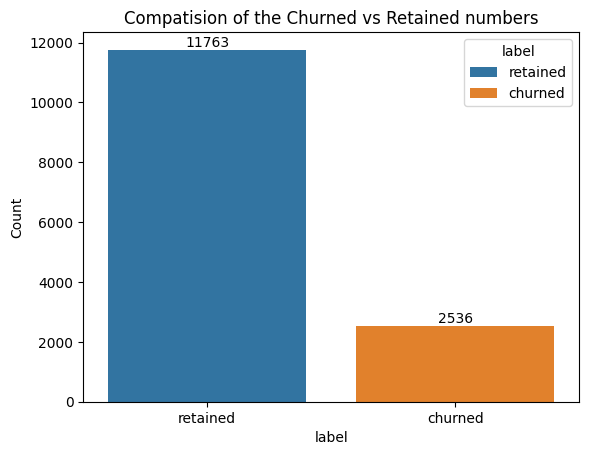

In [9]:
plot = sns.countplot(data = df, x = 'label', hue = 'label')
for bars in plot.containers:
    plot.bar_label(bars)

plt.title("Compatision of the Churned vs Retained numbers")
plt.ylabel('Count')
plt.show()

For the following we are calculaing the medians for each device types . The reason for calculating median is that the presence of outliers are most likely to deflect the present mean off the course

In [10]:
df.groupby('label',as_index=False).median(numeric_only=True)

,label,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
1,retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


This offers an interesting snapshot of the two groups, churned vs. retained: <br>
Users who churned averaged ~3 more drives in the last month than retained users, but retained users used the app on over twice as many days as churned users in the same time period. <br>
The median churned user drove ~200 more kilometers and 2.5 more hours during the last month than the median retained user. <br>
It seems that churned users had more drives in fewer days, and their trips were farther and longer in duration. Perhaps this is suggestive of a user profile. 


In [11]:
# Calculating the median kilometers per drive in the last month for both retained and churned users
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
# grouping the data with respect to label
df.groupby('label',as_index=False)['km_per_drive'].median()

,label,km_per_drive
0,churned,74.109416
1,retained,75.014702


Median Retained users tends to drive a kilometer more than the churned users

In [12]:
# Now calculating km driven per day of the recent month
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']
df.groupby('label',as_index = False)['km_per_driving_day'].median()

,label,km_per_driving_day
0,churned,697.541999
1,retained,289.549333


In [13]:
# Calculating the number of drives per driving day (day with atleast more than 1km drive recorded on app)
df['drives_per_driving_day'] = df['drives'] / df['driving_days']

df.groupby('label')[['drives_per_driving_day']].median()

,drives_per_driving_day
label,
churned,10.0000
retained,4.0625


In [14]:
print(f"ratio churned to retained user for drives_per_driving_day : {10/4.0625}")
print()
print(f"ratio churned to retained user for km_per_driving_day : {697.541999/289.549333}")

ratio churned to retained user for drives_per_driving_day : 2.4615384615384617

ratio churned to retained user for km_per_driving_day : 2.40906097683879


> Summary

1. The median user who churned drove 698 kilometers each day in their last month, which is almost ~2.4 times the per-drive-day distance of retained users. The median churned user had a similar ratio number of drives per drive day compared to retained users. <br>
2. It is clear from these figures that, regardless of whether a user churned or not, the users represented in this data are serious drivers! From a little reserach , any typical daily driver drives around 60 km (apprx) on an average. This genreal statistic is way less than to the one in the dataset we have. <br> 
3. It would probably be safe to assume that this data does not represent typical drivers at large. Perhaps the data ,and in particular the sample of churned users, contains a high proportion of long-haul truckers. <br>
In consideration of how much these users drive, it would be worthwhile to recommend to Waze that they gather more data on these super-drivers. It's possible that the reason for their driving so much is also the reason why the Waze app does not meet their specific set of needs.


Now jumping on to see whether the device type has any correlation to the label column

In [15]:
df.groupby('label',as_index=True)['device'].value_counts(normalize = True)*100

label     device 
churned   iPhone     64.865931
          Android    35.134069
retained  iPhone     64.439344
          Android    35.560656
Name: device, dtype: float64

The ratio of iPhone users and Android users is consistent between the churned group and the retained group

<a id="2"></a>
## 2. Exploratory Data Analysis (EDA)

In [16]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_drive,km_per_driving_day,drives_per_driving_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,11.632058,138.360267,11.894737
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,128.186173,1246.901868,9.727273
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,32.201567,382.393602,11.875000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,22.839778,304.530374,13.333333
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,58.091206,219.455667,3.777778


##### sessions : The number of occurrence of a user opening the app during the month

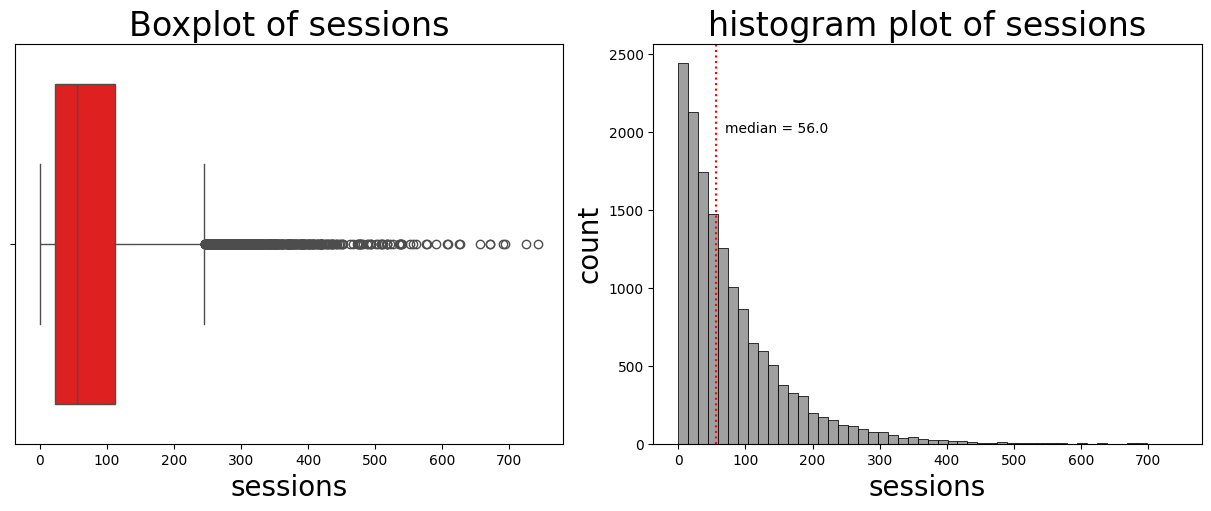

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot for the sessions
sns.boxplot(data = df, x = 'sessions', color = 'r', ax = axes[0])
axes[0].set_xlabel("sessions",fontsize = 20)
axes[0].set_title('Boxplot of sessions', fontsize=24)

#histogram plot
median_of_sessions = np.median(df['sessions'])
sns.histplot(data = df, x='sessions',bins =50,color='grey')
axes[1].axvline(median_of_sessions,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of sessions', fontsize=24)
axes[1].set_xlabel('sessions',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(70,2000,'median = 56.0')

plt.show()

*sessions* column is as a right skewed data , having a median of 56, meaning 50% of the values are lower than 56 sessions in the last month

##### total_sessions - A model estimate of the total number of sessions since a user has onboarded

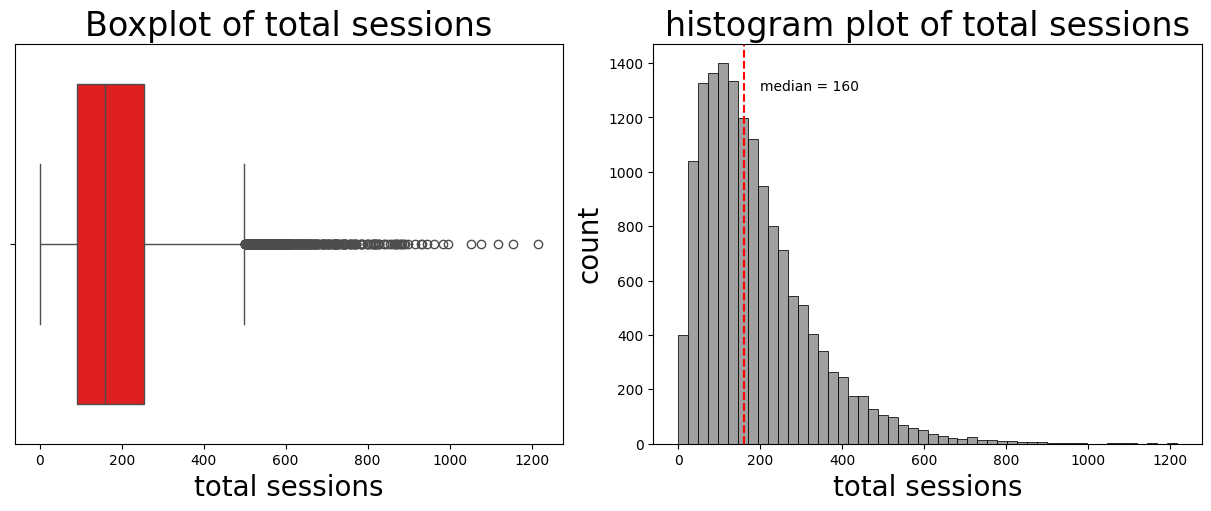

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot for the total_sessions
sns.boxplot(data = df, x = 'total_sessions', color = 'r', ax = axes[0])
axes[0].set_xlabel("total sessions",fontsize = 20)
axes[0].set_title('Boxplot of total sessions', fontsize=24)

#histogram plot
median_of_total_sessions = np.median(df['total_sessions'])
sns.histplot(data = df, x='total_sessions',bins =50,color='grey')
axes[1].axvline(median_of_total_sessions,color='red',ls="--",label='Median')
axes[1].set_title('histogram plot of total sessions', fontsize=24)
axes[1].set_xlabel('total sessions',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(200,1300,'median = 160')

plt.show()

The distribution for the label *total_session* is also right skewed, having the median as 160 (apprx).
Here we can observe an interesting point, This column has the session counts since the user registered that is 160 and the median session count for the last month is 56 accounting for the 35% usage of the app in the recent month.

##### drives - An occurrence of driving at least 1 km during the month

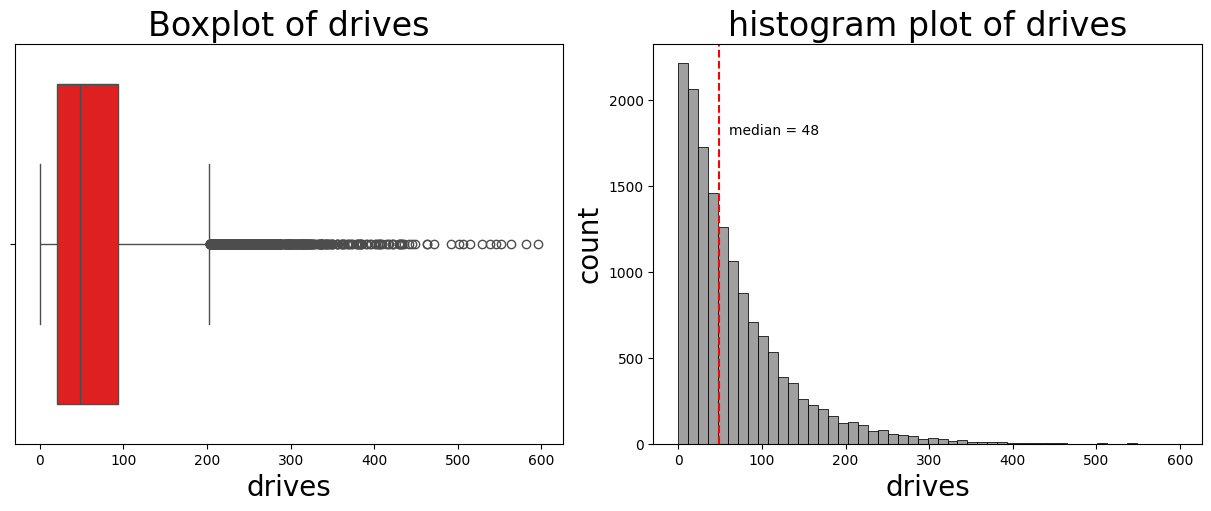

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("drives",fontsize = 20)
axes[0].set_title('Boxplot of drives', fontsize=24)

#histogram plot
median_of_drives = np.median(df['drives'])
sns.histplot(data = df, x='drives',bins =50,color='grey')
axes[1].axvline(median_of_drives,color='red',ls="--",label='Median')
axes[1].set_title('histogram plot of drives', fontsize=24)
axes[1].set_xlabel('drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(60,1800,'median = 48')

plt.show()

As expected, the distribution is similar to that of the session , medians are quite close (49,56), suggesting direct correlation between the 2 labels 

##### n_days_after_onboarding -The number of days since a user signed up for the app.

Text(1800, 650, 'median = 1741')

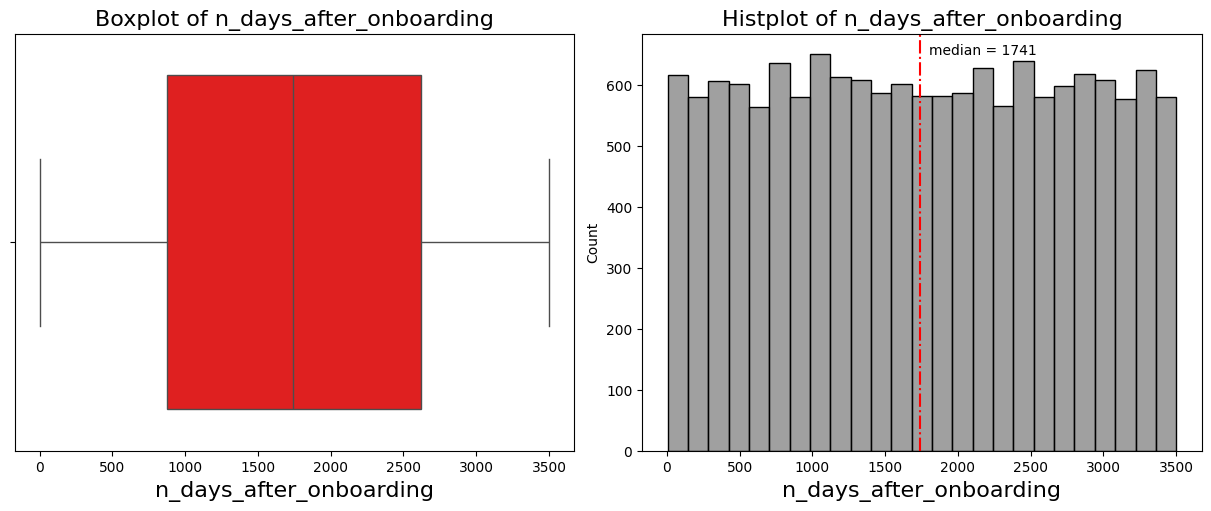

In [20]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(12,5),constrained_layout=True)

sns.boxplot(data=df,x='n_days_after_onboarding',color='r',ax=axes[0])
axes[0].set_xlabel('n_days_after_onboarding',fontsize=16)
axes[0].set_title("Boxplot of n_days_after_onboarding",fontsize=16)

median_onboarding = np.median(df['n_days_after_onboarding'])
sns.histplot(data=df,x='n_days_after_onboarding',color='grey')
axes[1].set_title("Histplot of n_days_after_onboarding",fontsize=16)
axes[1].axvline(median_onboarding,ls="-.",color='red')
axes[1].set_xlabel("n_days_after_onboarding",fontsize=16)
axes[1].text(1800,650,"median = 1741")

This distribution is quite uniform across all of the range , ranging from 0 to approximately 9.5 yeards of onboarding time on the app across various users

##### driven_km_drives.- Total kilometers driven during the month.

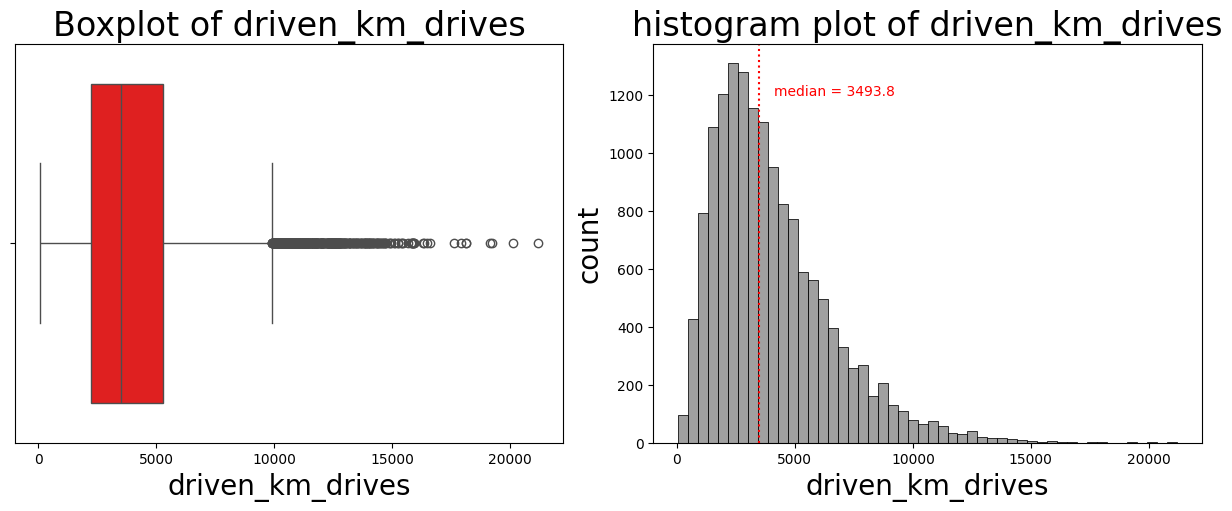

In [21]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'driven_km_drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("driven_km_drives",fontsize = 20)
axes[0].set_title('Boxplot of driven_km_drives', fontsize=24)

#histogram plot
median_total_km_driven = np.median(df['driven_km_drives'])
sns.histplot(data = df, x='driven_km_drives',bins =50,color='grey')
axes[1].axvline(median_total_km_driven,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of driven_km_drives', fontsize=24)
axes[1].set_xlabel('driven_km_drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(4100,1200,'median = 3493.8',color='red')

plt.show()

The distribution for the total km driven in the past month is right skewed and has a median of approximately 3500 kilometers, Meaning there are atleast 50% of people who are driving more then 100km per day (even after considering theu drive everysingle day)

##### duration_minutes_drives - Total duration driven (in minutes) during the month.

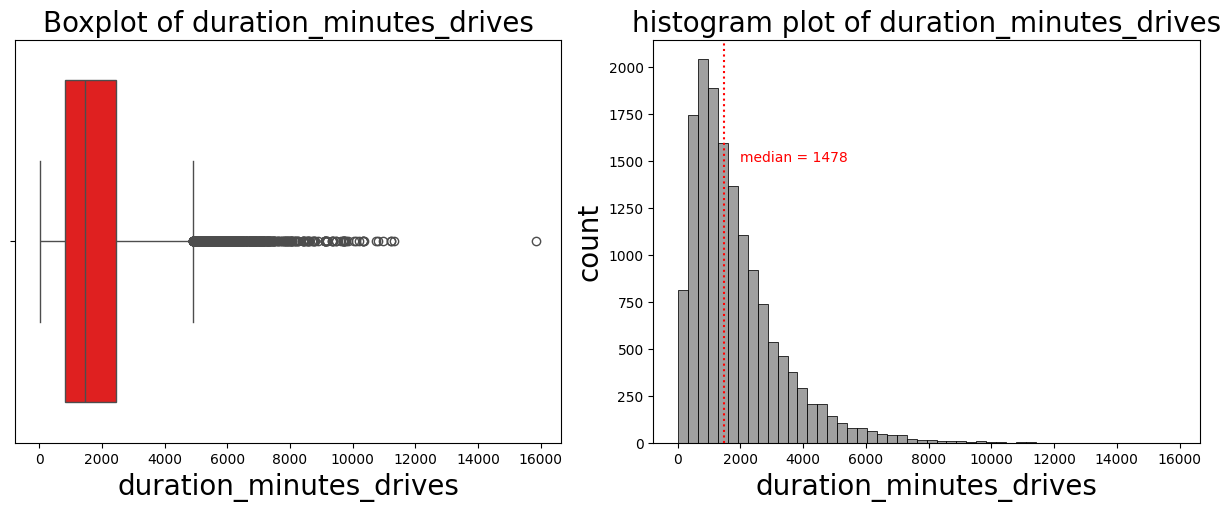

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'duration_minutes_drives', color = 'r', ax = axes[0])
axes[0].set_xlabel("duration_minutes_drives",fontsize = 20)
axes[0].set_title('Boxplot of duration_minutes_drives', fontsize=20)

#histogram plot
median_duration_minute_drive = np.median(df['duration_minutes_drives'])
sns.histplot(data = df, x='duration_minutes_drives',bins =50,color='grey')
axes[1].axvline(median_duration_minute_drive,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of duration_minutes_drives', fontsize=20)
axes[1].set_xlabel('duration_minutes_drives',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(2000,1500,'median = 1478',color='red')

plt.show()

The duration_minutes_drives variable has a heavily skewed right tail. Half of the users drove less than 1500 minutes (~25 hours).

##### activity_days - Number of days the user opens the app during the month.

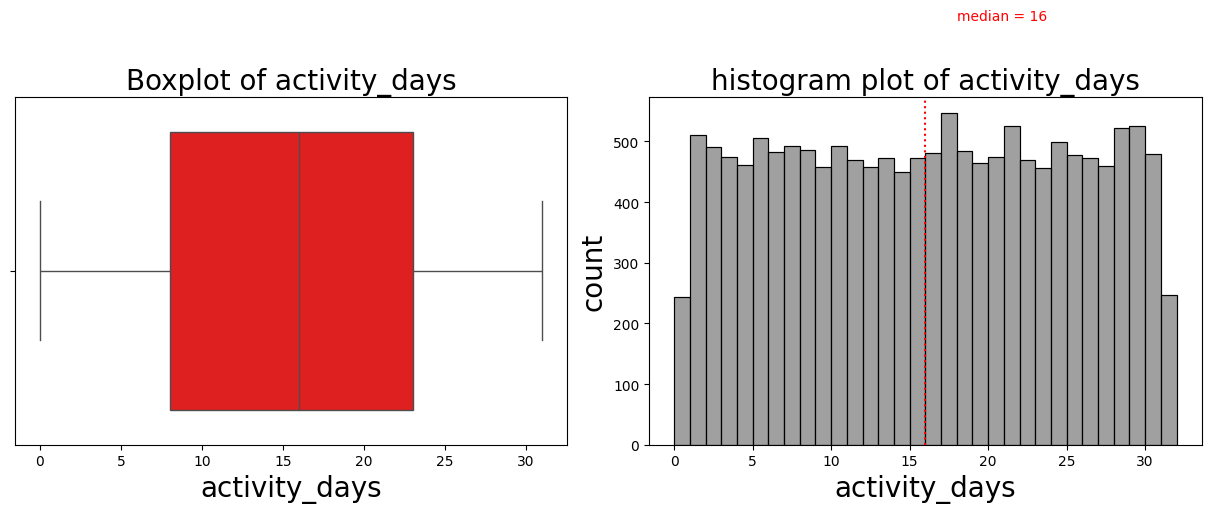

In [23]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'activity_days', color = 'r', ax = axes[0])
axes[0].set_xlabel("activity_days",fontsize = 20)
axes[0].set_title('Boxplot of activity_days', fontsize=20)

#histogram plot
median_activity_days = np.median(df['activity_days'])
sns.histplot(data = df, x='activity_days',bins =range(0,33),color='grey')
axes[1].axvline(median_activity_days,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of activity_days', fontsize=20)
axes[1].set_xlabel('activity_days',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(18,700,'median = 16',color='red')

plt.show()

Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 (14999/31) people opening the app on each count of days. <br>
This distribution is noteworthy because it does not mirror the *sessions* distribution, which you might think would be closely correlated with *activity_days*.



##### driving_days -  Number of days the user drives (at least 1 km) during the month.

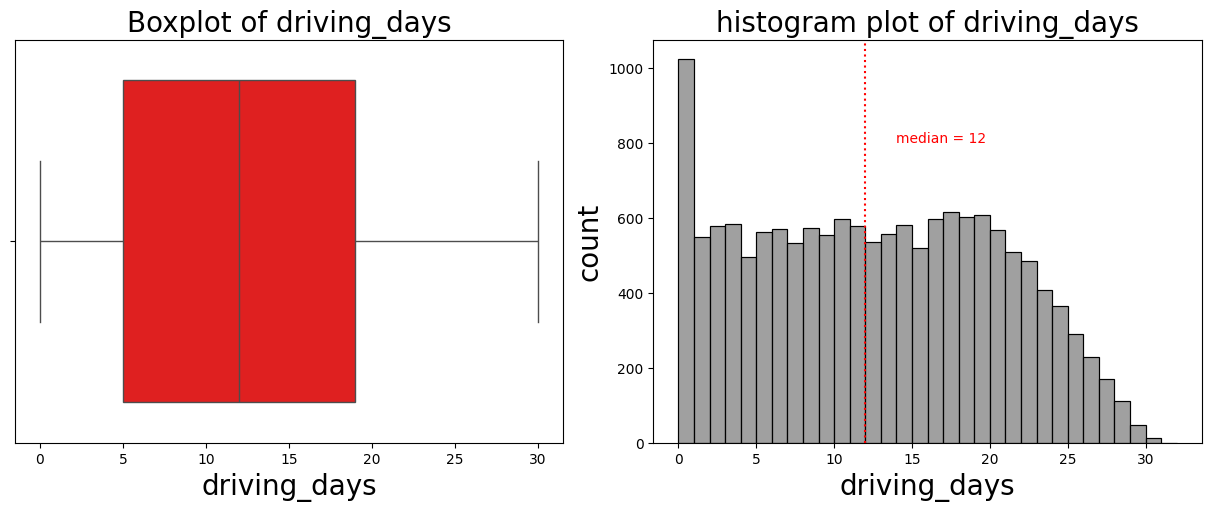

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (12,5),constrained_layout=True)

#boxplot 
sns.boxplot(data = df, x = 'driving_days', color = 'r', ax = axes[0])
axes[0].set_xlabel("driving_days",fontsize = 20)
axes[0].set_title('Boxplot of driving_days', fontsize=20)

#histogram plot
median_driving_days = np.median(df['driving_days'])
sns.histplot(data = df, x='driving_days',bins =range(0,33),color='grey')
axes[1].axvline(median_driving_days,color='red',ls=":",label='Median')
axes[1].set_title('histogram plot of driving_days', fontsize=20)
axes[1].set_xlabel('driving_days',fontsize=20)
axes[1].set_ylabel('count',fontsize=20)
axes[1].text(14,800,'median = 12',color='red')

plt.show()

This distribution highly correlates to the activity_days label except for the extreme ends of the distribution of the month. A median user opens the app 16 days and successfully drives more than a kilometer in 12 days . <br>
There are people who didnt drive at all in the recent month (~1100) .

Pie chart for the churned vs retained and pie chart for the device label

Text(0.5, 1.0, 'Retained vs Churned')

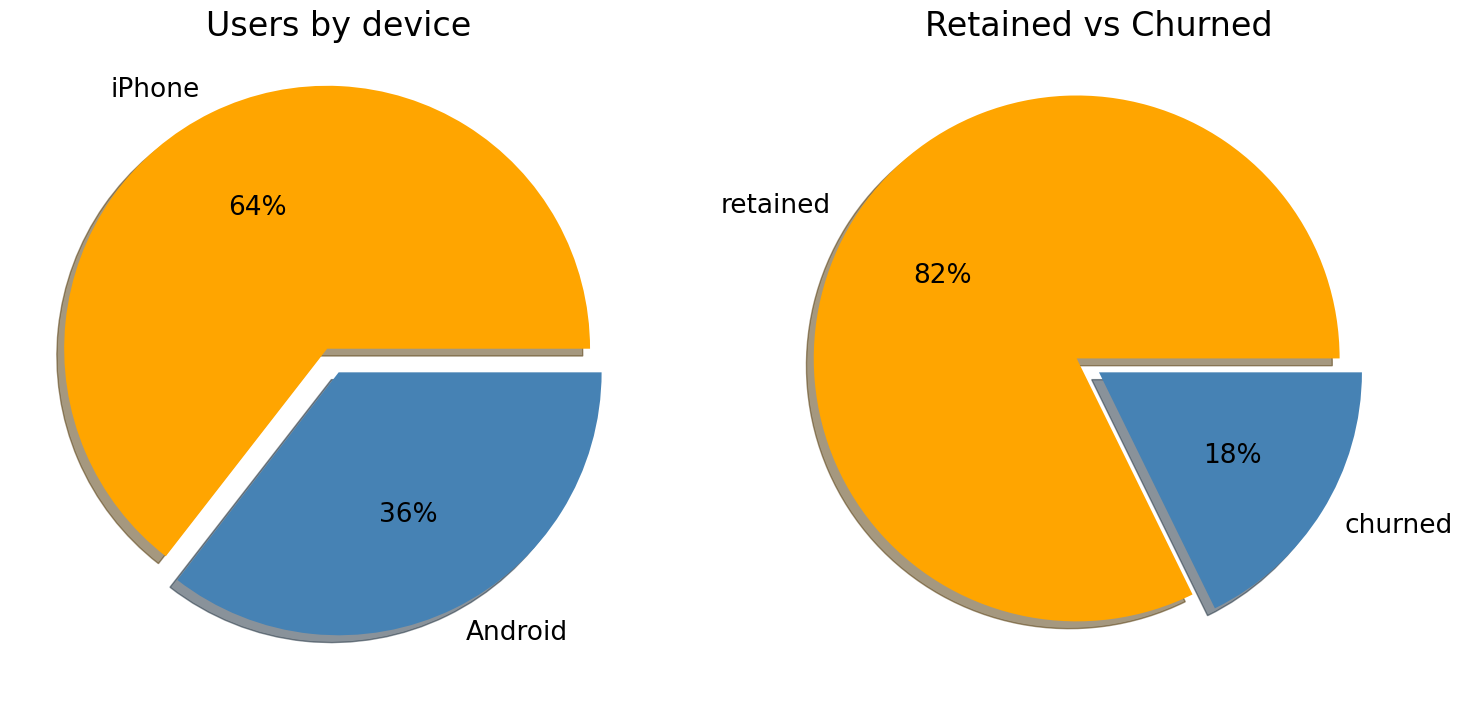

In [25]:
device = df['device'].value_counts()
status = df['label'].value_counts()

def function(val):
    return f'{val:.0f}%'

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,7), constrained_layout=True)

# plot for device
device.plot(kind='pie',autopct=function,textprops={'fontsize':19},ax=axes[0],explode=(0.1, 0.0),colors=["orange","steelblue"],shadow=True)
axes[0].set_ylabel("") # is shows a label withous using thos too , so i used this to remove the label
axes[0].set_title("Users by device",fontsize=24)

# plot for staus
status.plot(kind='pie',autopct=function,textprops={'fontsize':19},colors=["orange","steelblue"],explode=(0.1, 0.0),ax=axes[1],shadow=True)
axes[1].set_ylabel("")
axes[1].set_title("Retained vs Churned",fontsize=24)

Observation: 
1. There are nearly twice as many iPhone users as Android users represented in this data.
2. Less than 20% of the users churned.

##### activity_days vs driving_days

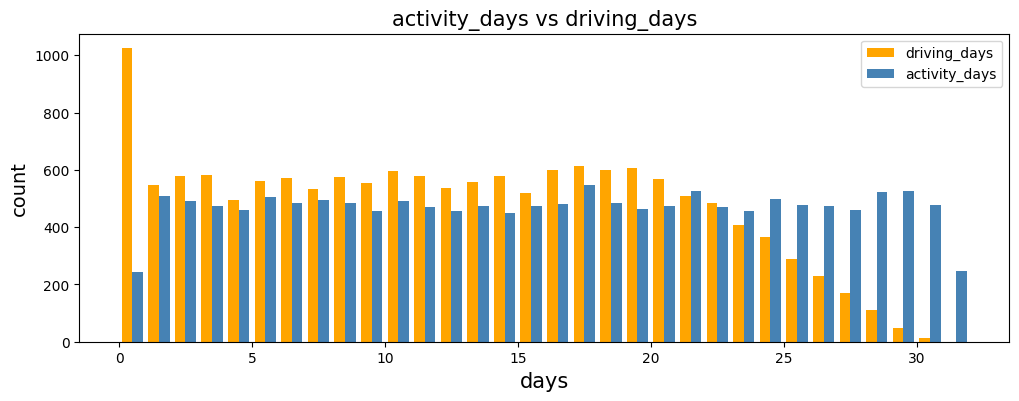

In [26]:
plt.figure(figsize=(12,4))
plt.hist(x = [df['driving_days'],df['activity_days']],bins=range(0,33),label=['driving_days','activity_days'],color=["orange","steelblue"])
plt.xlabel("days",fontsize=15)
plt.ylabel("count",fontsize=14)
plt.title("activity_days vs driving_days",fontsize=15)
plt.legend()
plt.show()

While these variables are related to each other, they are not the same. People probably just open the app more than they use the app to drive—perhaps to check drive times or route information, to update settings, or even just by mistake.

Checking the validity of the data

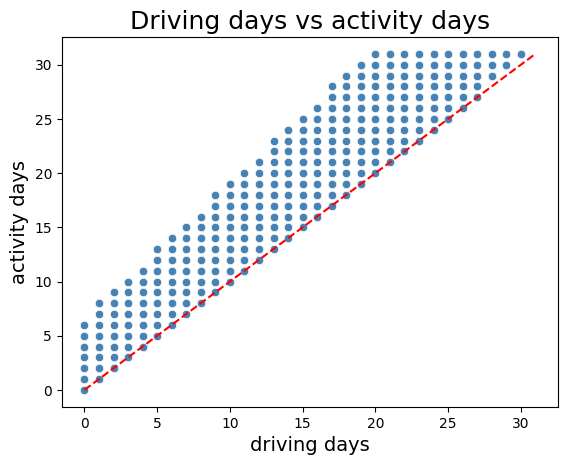

In [27]:
sns.scatterplot(data=df,x='driving_days',y='activity_days',color=["steelblue"])

plt.title('Driving days vs activity days',fontsize=18)
plt.xlabel('driving days',fontsize=14)
plt.ylabel('activity days',fontsize=14)
plt.plot([0,31],[0,31],color='red',linestyle='--');

So in theoratical terms a successful driving day should automatically be considered as a active day as the app is obviously in use corresponding to a successfull driving day. Now it is fairly possible, looking at the graph , for a user to open the app more than than driving more than a kilometer ,But vise vera is not possible for the record purposes (maybe possible practically is the app isnt used)

Retention by device

Text(0, 0.5, 'user count')

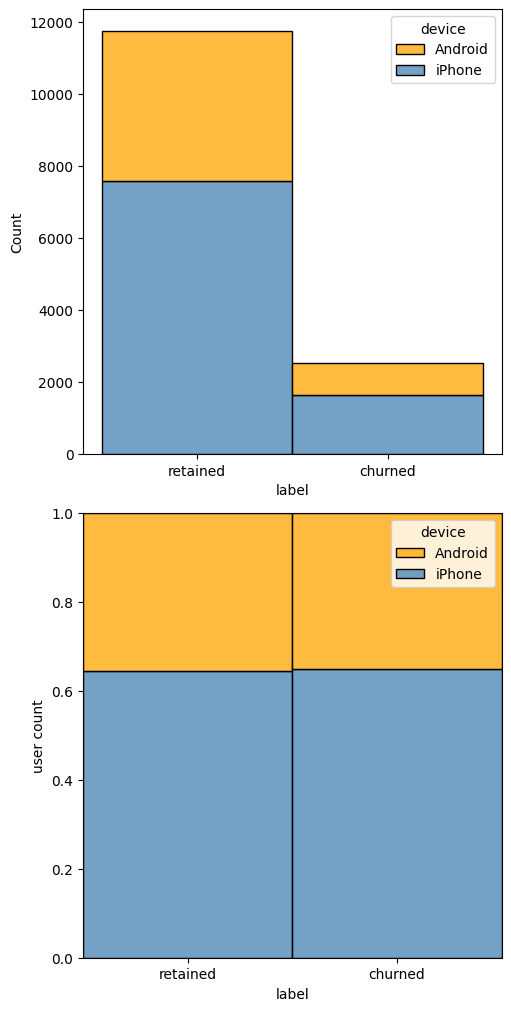

In [28]:
# checking whether the device category has any effect on the churn rate 
fig, axes = plt.subplots(2,1,figsize=(5,10),constrained_layout=True)

sns.histplot(data = df,x='label', hue='device',palette=['orange','steelblue'],multiple='stack',ax=axes[0])
sns.histplot(data = df,x='label', hue='device',palette=['orange','steelblue'],multiple='fill',ax=axes[1])
plt.ylabel("user count")

The proportion of churned users to retained users is consistent between device types.

**Retention by kilometers driven per driving day**

We discovered that the median distance driven per driving day last month for users who churned was 608.78 km, versus 247.48 km for people who did not churn. <br>
To study the 'km_per_driving_day' we will plot a fill histogram for this column

In [29]:
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Calculation of kilometers covered for each driving day was done by using driving_days , if it were to be zero then the output approaches infinite. Using numpy , replacing the infinite value with 0.

In [30]:
def replace(val):
    if val == np.inf:
        return 0
    else:
        return val

df['km_per_driving_day'] = df['km_per_driving_day'].apply(replace)

In [31]:
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

As it is quite clear, The max value in the column is 15000 km per day. Now for xample a person drives constantly at 100km/hr for 24 hours straight , total distance covered is still way less than the max value. <br>
So for the practical scenarios, i am considering that the max might go upto 800 kilometers is a driver drives at 100 km/hr for 12 hours straight in a day

> Churn rate by mean kilometer per driving day

Text(0.5, 1.0, 'Churned vs Retained by mean km per driving day')

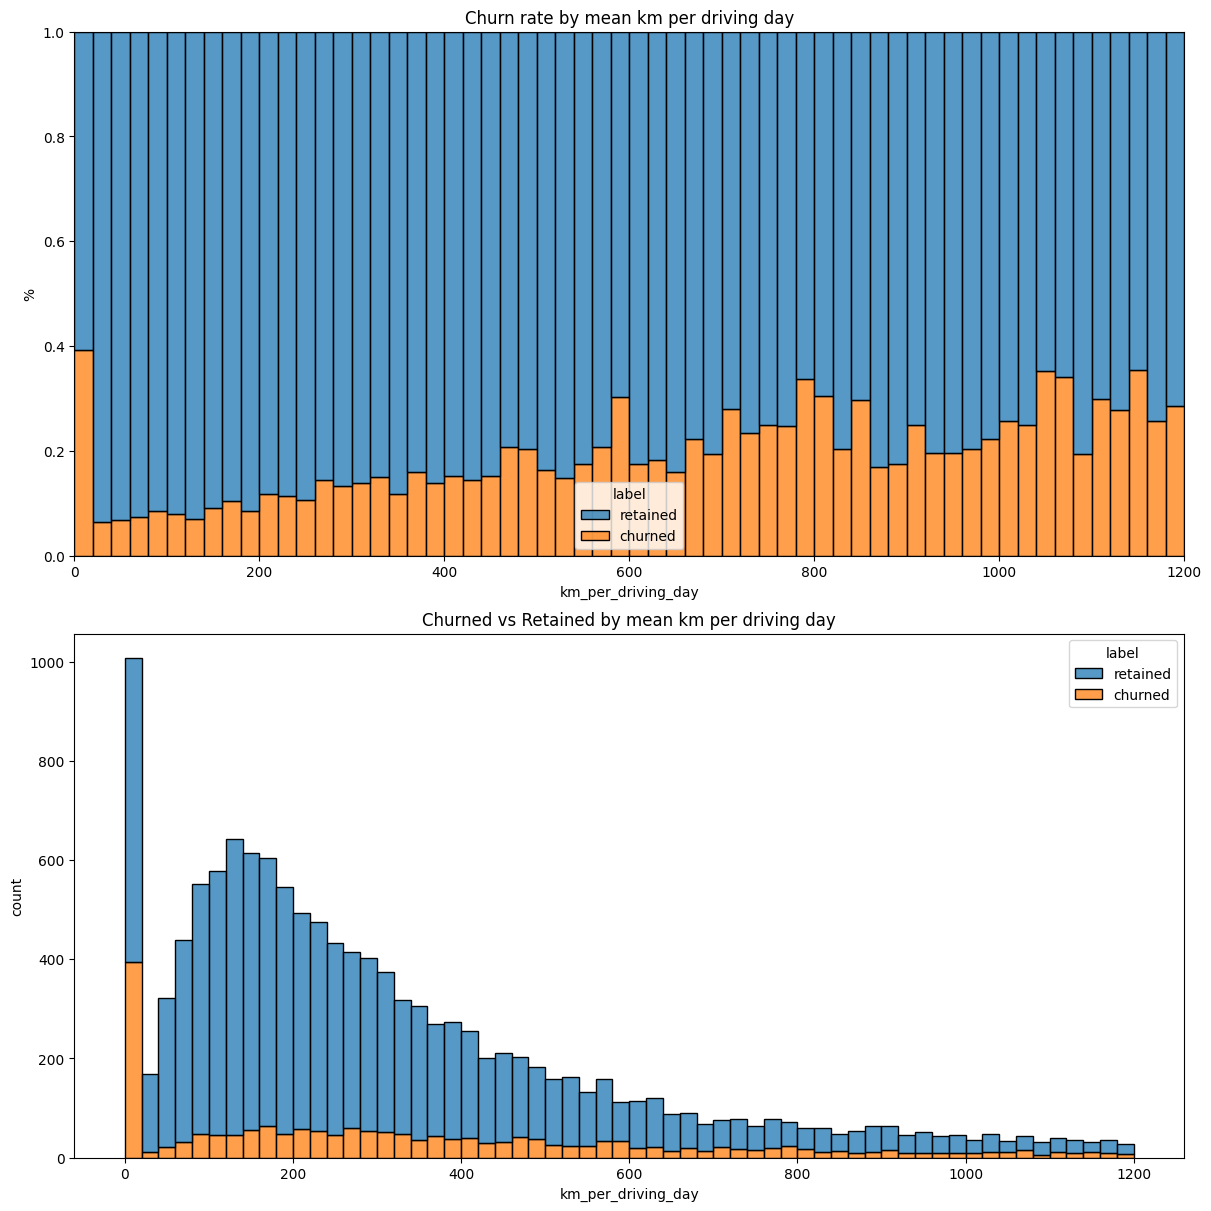

In [32]:
fig, axes = plt.subplots(2,1,figsize=(12,12),constrained_layout=True)

sns.histplot(data=df,x='km_per_driving_day',bins=range(0,1201,20),hue='label',multiple='fill',ax = axes[0])
axes[0].set_ylabel('%')
axes[0].set_title('Churn rate by mean km per driving day')

sns.histplot(data=df,x='km_per_driving_day',bins=range(0,1201,20),hue='label',multiple='stack',ax=axes[1])
axes[1].set_ylabel('count')
axes[1].set_title('Churned vs Retained by mean km per driving day')

> Observation:

1. It is quite evident from the graph that churn rate tends to increase with increase in the distance driven on a successful driving day. <br>
2. This indicates that investigating furthur with the long distance drivers will yield some positive results on resean for increase in the churn rate. <br>
3. Another visible fluctuation is the starting one. Users not using the app in the last month have quite high churn rate.

Churn rate with respect to driving_days

Text(0.5, 1.0, 'Churn rate by driving_days')

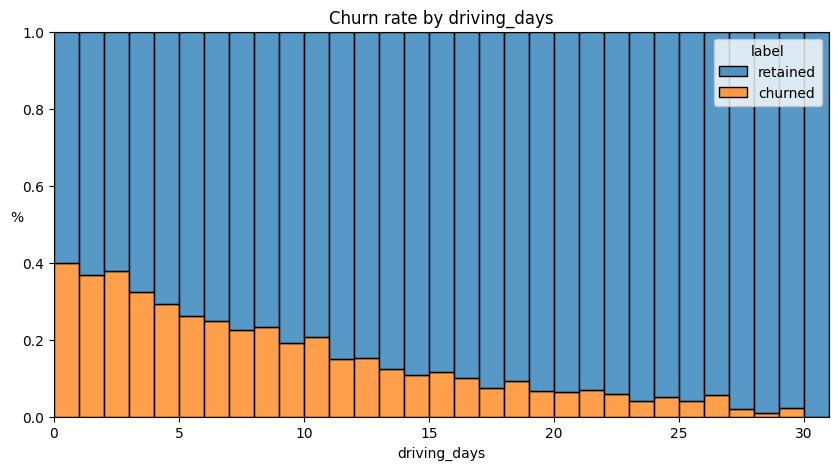

In [33]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='driving_days',hue='label',multiple='fill',bins=range(0,32,1))
plt.ylabel("%",rotation=0)
plt.title("Churn rate by driving_days")

The churn rate is highest for people who didn't use Waze much during the last month. The more times they used the app, the less likely they were to churn. While 40% of the users who didn't use the app at all last month churned, nobody who used the app 30 days churned.

This isn't surprising. If people who used the app a lot churned, it would likely indicate dissatisfaction. When people who don't use the app churn, it might be the result of dissatisfaction in the past, or it might be indicative of a lesser need for a navigational app. Maybe they moved to a city with good public transportation and don't need to drive anymore.

Proportion of the sessions that happened in the last month


In [34]:
df['percent_sessions_last_month'] = df['sessions'] / df['total_sessions']
df['percent_sessions_last_month'].median()

0.42309702992763176

Almost half or more users have had 42% of their WAZE app sessions in the recent month out of their total sessions since they joined the app

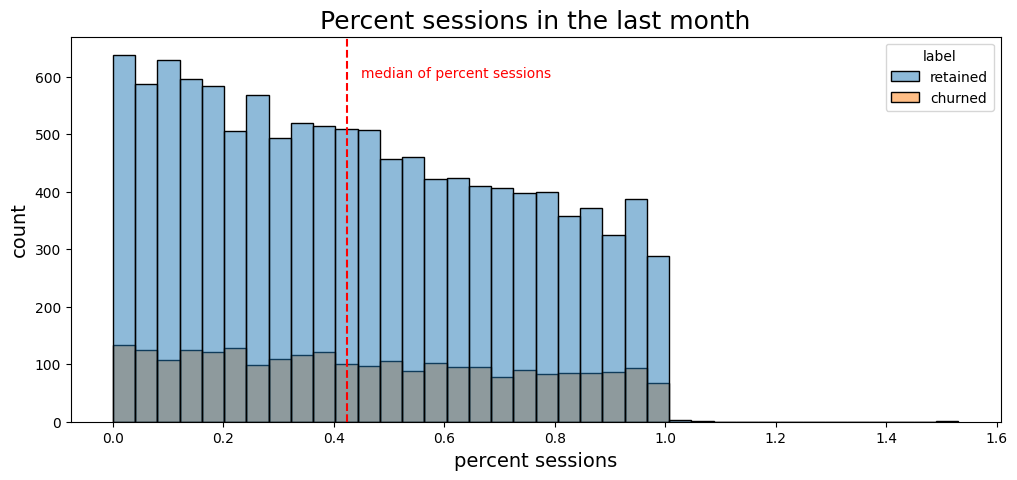

In [35]:
plt.figure(figsize=(12,5))
median_sesss = np.median(df['percent_sessions_last_month'])
sns.histplot(data=df,x='percent_sessions_last_month',hue='label')
plt.axvline(median_sesss,color="red",ls="--")
plt.text(0.45,600,'median of percent sessions',color='red')
plt.xlabel('percent sessions',fontsize=14)
plt.ylabel('count',fontsize=14)
plt.title('Percent sessions in the last month',fontsize=18);

The churn rate across this distribution looks uniform with the median percent sessions = 0.42

> Professional Driver

One other criteria for judging the churn rate is under the category of the professional and non professional drivers

**Defining a criteria**: User with atleast 60 drives and 15+ driving days in the recent month is classified as a professional driver

Professional driver is given label --> 1 <br>
Non-Professional driver is given label --> 0

In [36]:
# Creating the column 'Professional_driver'
df['professional_driver'] = np.where((df['driving_days']>=15)&(df['drives']>=60),1,0)

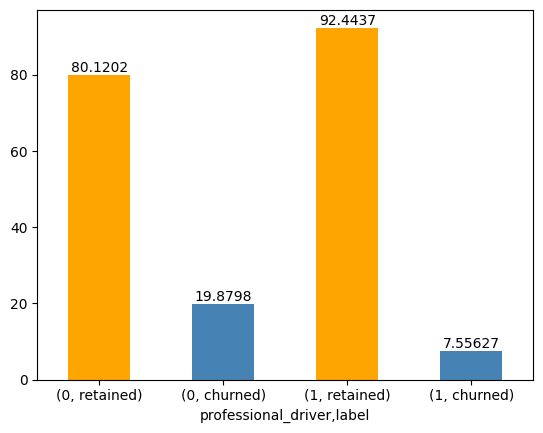

In [37]:
plot = (df.groupby('professional_driver',as_index=True)['label'].value_counts(normalize=True)*100).plot(kind='bar',color=['orange','steelblue'])
for bars in plot.containers:
    plot.bar_label(bars)
plt.xticks(rotation=0)
plt.show()

The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

#### Data cleansing and Outlier removal

**Drop null values**

Drop rows with missing data in the *label* column.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           14999 non-null  int64  
 1   label                        14299 non-null  object 
 2   sessions                     14999 non-null  int64  
 3   drives                       14999 non-null  int64  
 4   total_sessions               14999 non-null  float64
 5   n_days_after_onboarding      14999 non-null  int64  
 6   total_navigations_fav1       14999 non-null  int64  
 7   total_navigations_fav2       14999 non-null  int64  
 8   driven_km_drives             14999 non-null  float64
 9   duration_minutes_drives      14999 non-null  float64
 10  activity_days                14999 non-null  int64  
 11  driving_days                 14999 non-null  int64  
 12  device                       14999 non-null  object 
 13  km_per_drive    

In [39]:
df.dropna(subset='label',inplace=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14299 entries, 0 to 14998
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           14299 non-null  int64  
 1   label                        14299 non-null  object 
 2   sessions                     14299 non-null  int64  
 3   drives                       14299 non-null  int64  
 4   total_sessions               14299 non-null  float64
 5   n_days_after_onboarding      14299 non-null  int64  
 6   total_navigations_fav1       14299 non-null  int64  
 7   total_navigations_fav2       14299 non-null  int64  
 8   driven_km_drives             14299 non-null  float64
 9   duration_minutes_drives      14299 non-null  float64
 10  activity_days                14299 non-null  int64  
 11  driving_days                 14299 non-null  int64  
 12  device                       14299 non-null  object 
 13  km_per_drive    

700 rows with respect to the label column are removed, Now only 14299 entries remain in the data set

In [41]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_last_month,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,1.429900e+04,14299.000000,1.429200e+04,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530,inf,581.942399,inf,0.449837,0.173998
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835,NaN,1038.254509,NaN,0.286863,0.379121
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,1.008775e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,3.325389e+01,136.168003,1.800000e+00,0.196890,0.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,7.490594e+01,273.301012,4.666667e+00,0.424310,0.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,1.854667e+02,558.018761,1.220000e+01,0.687251,0.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,inf,15420.234110,inf,1.530637,1.000000


In [42]:
cols = ['km_per_drive','km_per_driving_day']

for i in cols:
    df.replace(np.inf,sorted(df[i].unique())[-2],inplace=True)
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_last_month,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14292.000000,14299.000000,14299.000000
mean,7503.573117,80.623820,67.255822,189.547409,1751.822505,121.747395,29.638296,4044.401535,1864.199794,15.544653,12.182530,344.815354,581.942399,1086.804710,0.449837,0.173998
std,4331.207621,80.736502,65.947295,136.189764,1008.663834,147.713428,45.350890,2504.977970,1448.005047,9.016088,7.833835,1445.876545,1038.254509,3977.394321,0.286863,0.379121
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,1.008775,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,33.253894,136.168003,1.800000,0.196890,0.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,74.905935,273.301012,4.666667,0.424310,0.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,185.466720,558.018761,12.200000,0.687251,0.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000,15777.426560,15420.234110,15777.426560,1.530637,1.000000


#### Outliers

Boxplots above indicated presence of outliers lying in most of the labels.These outliers do not seem to be data entry errors; they are present because of the right-skewed distributions. <br>
One way of performing this imputation is to set a threshold based on a percentile of the distribution.

In [43]:
def outlier_imputer(column_name,percentile):
    # Calculate threshold
    threshold = df[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df.loc[df[column_name] > threshold,column_name] = threshold

    print('{} | percentile: {} | threshold: {}'.format(column_name,percentile,threshold))

In [44]:
for column in ['sessions','drives','total_sessions','driven_km_drives','duration_minutes_drives',
               'total_navigations_fav1','total_navigations_fav2']: 
    outlier_imputer(column,0.95)  

sessions | percentile: 0.95 | threshold: 243.0
drives | percentile: 0.95 | threshold: 200.0
total_sessions | percentile: 0.95 | threshold: 455.4394923899998
driven_km_drives | percentile: 0.95 | threshold: 8898.716274999999
duration_minutes_drives | percentile: 0.95 | threshold: 4668.180091799999
total_navigations_fav1 | percentile: 0.95 | threshold: 422.0
total_navigations_fav2 | percentile: 0.95 | threshold: 124.0


In [45]:
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_drive,km_per_driving_day,drives_per_driving_day,percent_sessions_last_month,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14292.000000,14299.000000,14299.000000
mean,7503.573117,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,344.815354,581.942399,1086.804710,0.449837,0.173998
std,4331.207621,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1445.876545,1038.254509,3977.394321,0.286863,0.379121
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,1.008775,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,33.253894,136.168003,1.800000,0.196890,0.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,74.905935,273.301012,4.666667,0.424310,0.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,185.466720,558.018761,12.200000,0.687251,0.000000
max,14998.000000,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15777.426560,15420.234110,15777.426560,1.530637,1.000000


### EDA conclusion

The analysis revealed that the overall churn rate is ~17%, and that this rate is consistent between iPhone users and Android users.

Perhaps i feel that the more deeply i explore the data, the more questions arise. In this case, it's worth asking the Waze data team why so many users used the app so much in just the last month.

Also, EDA has revealed that users who drive very long distances on their driving days are more likely to churn, but users who drive more often are less likely to churn. The reason for this discrepancy is an opportunity for further investigation, and it would be something else to ask the Waze data team about.

<a id="3"></a>
## 3. Hypothesis Testing

**Note.** In the dataset, device is a categorical variable with the labels iPhone and Android. <br>
In order to perform this analysis, label into an integer conversion is necessary. The following code assigns a 1 for an iPhone user and a 2 for Android. It assigns this label back to the variable device_type.

In [46]:
# 1. Create `map_dictionary`
map_dictionary = {'Android': 2, 'iPhone': 1}

# 2. Create new `device_type` column
df['device_type'] = df['device']

# 3. Map the new column to the dictionary
df['device_type'] = df['device_type'].map(map_dictionary)

df['device_type'].head()

0    2
1    1
2    2
3    1
4    2
Name: device_type, dtype: int64

I am interested in the relationship between device type and the number of drives. One approach is to look at the average number of drives for each device type. Calculate these averages.

In [47]:
df.groupby('device_type')['drives'].mean()

device_type
1    64.442385
2    63.096177
Name: drives, dtype: float64

Based on the averages shown, it appears that drivers who use an iPhone device to interact with the application have a higher number of drives on average. However, this difference might arise from random sampling, rather than being a true difference in the number of drives. To assess whether the difference is statistically significant, you can conduct a hypothesis test.

**Hypothesis testing**

My goal is to conduct a two-sample t-test. Steps for conducting a hypothesis test:

1. State the null hypothesis and the alternative hypothesis
2. Choose a signficance level
3. Find the p-value
4. Reject or fail to reject the null hypothesis

Note: This is a t-test for two independent samples. This is the appropriate test since the two groups are independent (Android users vs. iPhone users).

Hypotheses:

1. $𝐻_0$: There is no difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.
2. $𝐻_{\rm 𝐴}$: There is a difference in average number of drives between drivers who use iPhone devices and drivers who use Androids.

In [48]:
from scipy import stats
# 1. Isolate the `drives` column for iPhone users.
iPhone = df[df['device_type'] == 1]['drives']

# 2. Isolate the `drives` column for Android users.
Android = df[df['device_type'] == 2]['drives']

# 3. Perform the t-test
stats.ttest_ind(a=iPhone, b=Android, equal_var=False)

Ttest_indResult(statistic=1.4057121891392934, pvalue=0.1598388152623599)

Since the p-value is larger than the chosen significance level (5%), failure to reject the null hypothesis. <br>
I conclude that there is not a statistically significant difference in the average number of drives between drivers who use iPhones and drivers who use Androids.

<a id="4"></a>
## 4. Build a Logistic Regression Model

**Encode 'label' and 'device' variables**

Change the data type of the *label* column to be binary. This change is needed to train a logistic regression model.

1. Assign a 0 for all retained users.
2. Assign a 1 for all churned users.

Save this variable as label2 as to not overwrite the original label variable.

In [49]:
# Create binary `label2` column
df['label'] = np.where(df['label']=='churned', 1, 0)

Create a new, binary column called device2 that encodes user devices as follows:

1. Android -> 0
2. iPhone -> 1

In [50]:
# Create binary `label2` column
df['device'] = np.where(df['device']=='Android',0,1)

In [51]:
df.head()
df.dropna(axis=0,inplace=True)

**Collinearity**

generate a correlation matrix.

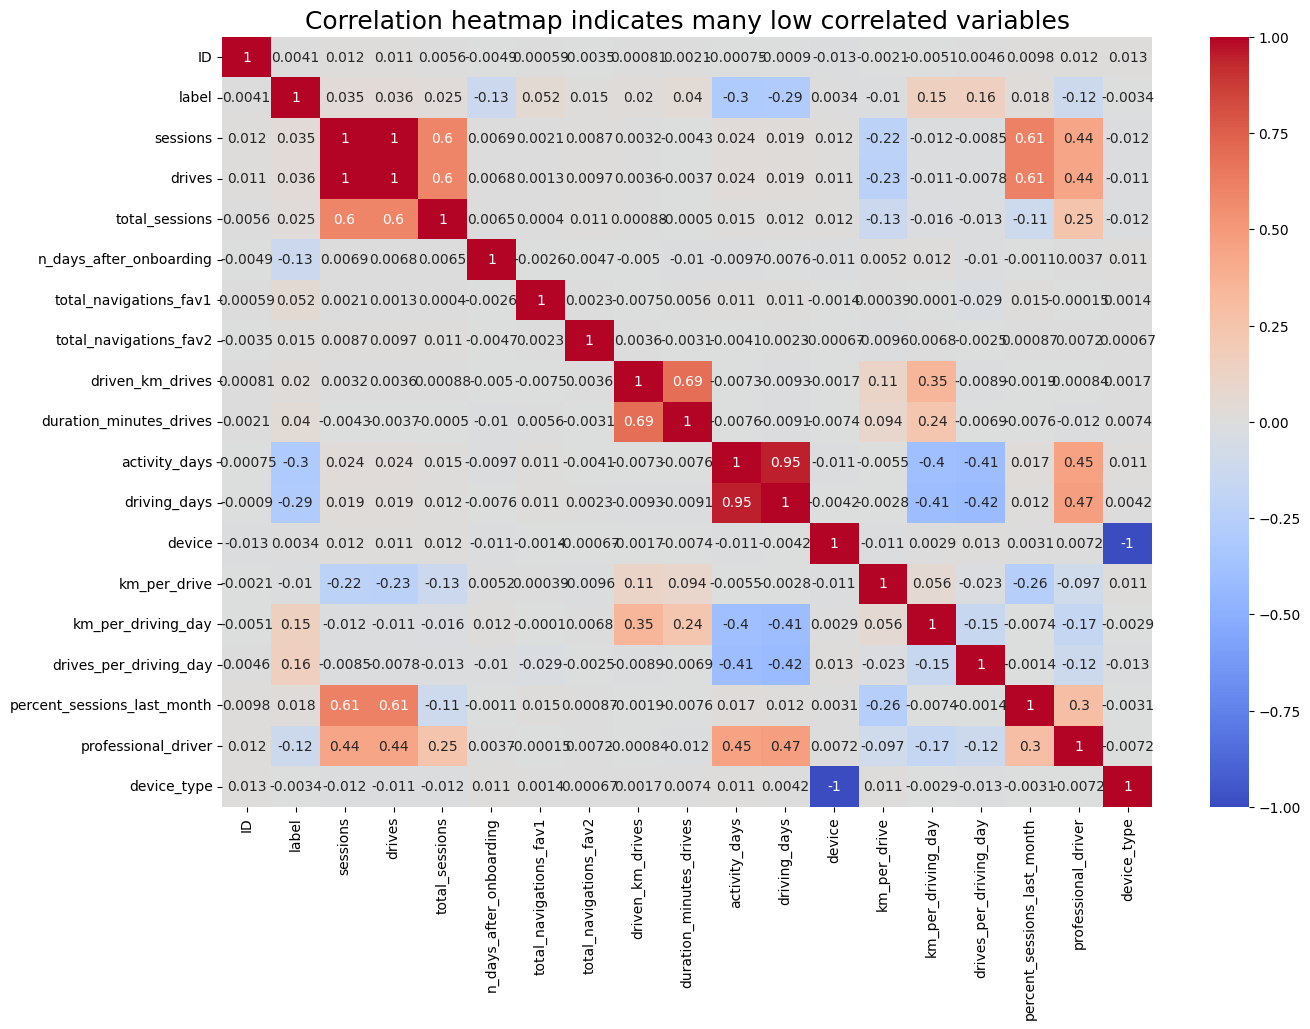

In [52]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(method='pearson'),vmin=-1,vmax=1,annot=True,cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',fontsize=18)
plt.show()

Predictor variables that have a Pearson correlation coefficient value greater than the absolute value of 0.7, these variables are strongly multicollinear. Therefore, only one of these variables should be used in model. <br>
(0.7 is an arbitrary threshold.)

### Model building

In [53]:
y = df['label']

X = df.drop(columns = ['ID','label','device','sessions','driving_days','percent_sessions_last_month'])

In [54]:
# train teest split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2,random_state=42)

X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_drive,km_per_driving_day,drives_per_driving_day,professional_driver,device_type
10959,29,133.982798,2122,422,0,6255.958024,3496.231327,27,215.722690,367.997531,1.705882,0,1
2686,89,455.439492,2853,422,7,8898.716275,4668.180092,5,120.262753,0.000000,15777.426560,0,2
27,5,215.876461,2465,412,0,925.030474,490.534675,16,185.006095,115.628809,0.625000,0,1
10898,73,314.571757,1321,46,10,3344.133451,1101.914679,20,45.810047,176.007024,3.842105,1,1
6930,23,117.908753,2253,411,0,5066.770273,4109.092583,11,220.294360,460.615479,2.090909,0,2


In [55]:
model = LogisticRegression()

model.fit(X_train,y_train)

C:\Users\arins\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [56]:
pd.Series(model.coef_[0],index=X.columns)

drives                    -0.000021
total_sessions             0.000777
n_days_after_onboarding   -0.000420
total_navigations_fav1     0.000944
total_navigations_fav2     0.001359
driven_km_drives          -0.000040
duration_minutes_drives    0.000119
activity_days             -0.093511
km_per_drive              -0.000004
km_per_driving_day         0.000058
drives_per_driving_day     0.000009
professional_driver       -0.001420
device_type               -0.002800
dtype: float64

In [57]:
model.intercept_

array([-0.00208714])

**final assumption**

linear relationship between *X* and the estimated log odds (known as logits) by making a regplot.


In [58]:
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93911027, 0.06088973],
       [0.64202373, 0.35797627],
       [0.87584402, 0.12415598],
       ...,
       [0.58930544, 0.41069456],
       [0.83435092, 0.16564908],
       [0.93105939, 0.06894061]])

In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. <br>

In [59]:
# 1. Copying the `X_train` dataframe to `logit_data`
logit_data = X_train.copy()

# 2.new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

regplot where the *x*-axis represents an independent variable and the *y*-axis represents the log-odds of the predicted probabilities. 

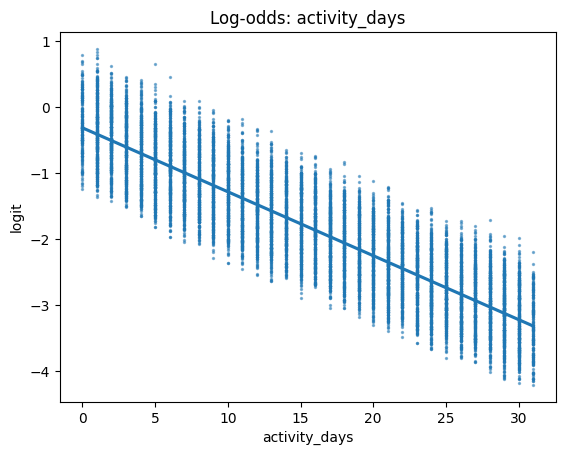

In [60]:
sns.regplot(x='activity_days',y='logit',data=logit_data,scatter_kws={'s':2,'alpha':0.5})
plt.title('Log-odds: activity_days');

### Results and evaluation

In [61]:
y_preds = model.predict(X_test)

In [62]:
# Score the model (accuracy) on the test data
model.score(X_test,y_test)

0.8272123119972018

**Confusion matrix**

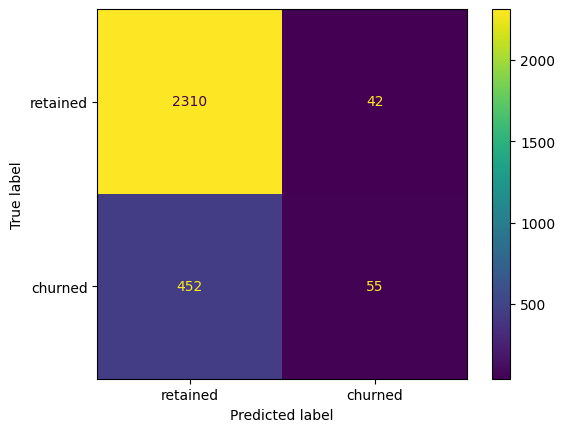

In [63]:
cm = confusion_matrix(y_test,y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['retained','churned'])
disp.plot();

**Classification report**

In [64]:
target_labels = ['retained','churned']
print(classification_report(y_test,y_preds,target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.84      0.98      0.90      2352
     churned       0.57      0.11      0.18       507

    accuracy                           0.83      2859
   macro avg       0.70      0.55      0.54      2859
weighted avg       0.79      0.83      0.78      2859



**Note.** The model has mediocre precision and very low recall, which means that it makes a lot of false negative predictions and fails to capture users who will churn.

<a id="5"></a>
## 5. Machine Learning Model

Splitting the Already split train data into furthur train and  validation sets

In [65]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y_train,stratify=y_train,test_size=0.25,random_state=42)

Verification of the 60/20/20 split


In [66]:
for i in [X_tr,X_val,X_test]:
    print(f"number of samples : {len(i)}")

number of samples : 8574
number of samples : 2859
number of samples : 2859


### Modelling

**Random forest**

Beginning with GridSearchCV to tune a random forest model.

Steps that i will follow:

1. Instantiate the random forest classifier object.
2. Create a dictionary *cv_params* : 

- max_depth
- max_features
- max_samples 
- min_samples_leaf
- min_samples_split
- n_estimators

3. Define a set scoring of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).
4. Instantiate the GridSearchCV object rf_cv. Pass to it as arguments:

- estimator = rf
- param_grid = cv_params
- scoring = scoring
- cv: define the number of cross-validation folds you want (*cv=_*)
- refit: indicate which evaluation metric you want to use to select the model (*refit=_*)

*refit* should be set to *recall*.

In [67]:
rf = RandomForestClassifier(random_state=42)

cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2,5],
             'min_samples_split': [2,5],
             'n_estimators': [300],}

scoring = {'accuracy','precision','recall','f1'}

rf_cv = GridSearchCV(rf,cv_params,scoring=scoring,cv=5,refit='recall')

Fitting the model to train data and saving the model for future use using *pickle*

In [68]:
#%%time
#rf_cv.fit(X_tr,y_tr) 

# model saved using the pickle

path = 'C:/Users/arins/OneDrive/Documents/Desktop/Data Analytics/Advanced Data Analysis/WAZE data project/github/'
#with open(path + 'rf_cv_model_p.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)

# pickle used to import the model
with open(path + 'rf_cv_model_p.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

Examine the best average score across all the validation folds.

In [69]:
rf_cv.best_score_

0.12302631578947368

Examine the best combination of hyperparameters.

In [70]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

Defining a function to make the results table for each model

In [71]:
def make_results(model_name:str,model_object,metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'}

    cv_results = pd.DataFrame(model_object.cv_results_) # df of returned dictionary of numpy arrays

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy],},)

    return table

In [72]:
results = make_results('RF cv',rf_cv,'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.436578,0.123026,0.191901,0.816422


**XGBoost**

Finding the scores using an XGBoost model.

Steps for the same i followed
1. Instantiate the XGBoost classifier xgb and set objective='binary:logistic'.
2. Create a dictionary *cv_params* of the following hyperparameters and their corresponding values to tune:

- max_depth
- min_child_weight
- learning_rate
- n_estimators

3. Define a set scoring of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).
4. Instantiate the GridSearchCV object *xgb_cv*. Pass to it as arguments:

- estimator=xgb
- param_grid=cv_params
- scoring=scoring
- cv: define the number of cross-validation folds .
- refit: indicate which evaluation metric you want to use to select the model (refit='recall')

In [73]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]}

scoring = {'accuracy','precision','recall','f1'}


xgb_cv = GridSearchCV(xgb,cv_params,scoring=scoring,cv=4,refit='recall')

In [74]:
%%time
xgb_cv.fit(X_tr,y_tr)

CPU times: total: 4min 14s
Wall time: 19.3 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring={'f1', 'accuracy', 'precision', 'recall'})

In [75]:
xgb_cv.best_score_

0.1631578947368421

In [76]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

In [77]:
xgb_cv_results = make_results('XGB cv',xgb_cv,'recall')
results = pd.concat([results,xgb_cv_results],axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.436578,0.123026,0.191901,0.816422
0,XGB cv,0.388396,0.163158,0.229582,0.805808


### Model selection

Now, using the best random forest model and the best XGBoost model i'll predict on the validation data. Whichever performs better will be selected as the champion model.

Random Forest

In [78]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [79]:
def get_test_scores(model_name:str,preds,y_test_data):
    '''
    Generate a table of test scores.

        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data
    '''
    accuracy = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds)
    recall = recall_score(y_test_data,preds)
    f1 = f1_score(y_test_data,preds)

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table

In [80]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val',rf_val_preds,y_val)

# Append to the results table
results = pd.concat([results,rf_val_scores],axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.436578,0.123026,0.191901,0.816422
0,XGB cv,0.388396,0.163158,0.229582,0.805808
0,RF val,0.448276,0.128205,0.199387,0.817419


**XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [81]:
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

xgb_val_scores = get_test_scores('XGB val',xgb_val_preds,y_val)

results = pd.concat([results,xgb_val_scores],axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.436578,0.123026,0.191901,0.816422
0,XGB cv,0.388396,0.163158,0.229582,0.805808
0,RF val,0.448276,0.128205,0.199387,0.817419
0,XGB val,0.400000,0.149901,0.218077,0.809374


### Use champion model to predict on test data

In [82]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test',xgb_test_preds,y_test)

# Append to the results table
results = pd.concat([results,xgb_test_scores],axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.436578,0.123026,0.191901,0.816422
0,XGB cv,0.388396,0.163158,0.229582,0.805808
0,RF val,0.448276,0.128205,0.199387,0.817419
0,XGB val,0.400000,0.149901,0.218077,0.809374
0,XGB test,0.354369,0.143984,0.204769,0.801679


**Confusion matrix**

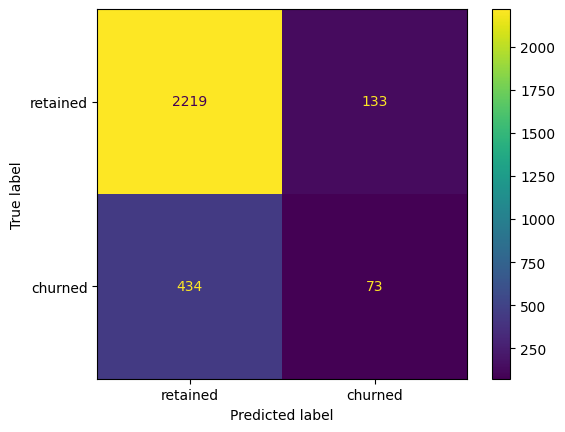

In [83]:
cm = confusion_matrix(y_test,xgb_test_preds,labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['retained','churned'])
disp.plot();

**Feature importance**

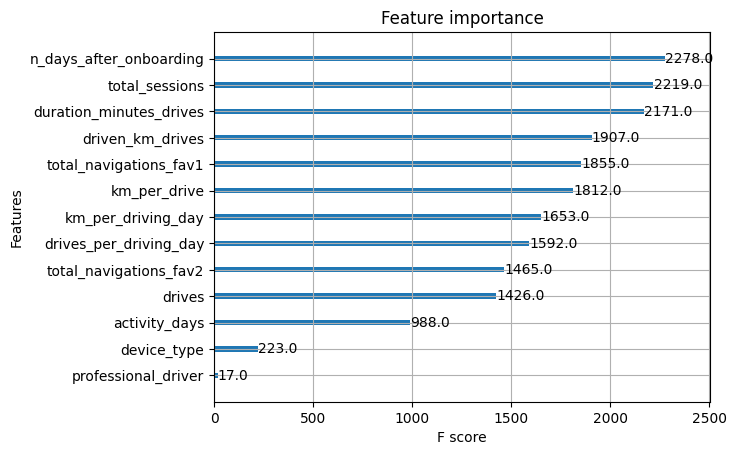

In [84]:
plot_importance(xgb_cv.best_estimator_);

* F score above is the 'frequency in XGBoost'  <br>
Feature importance scores give you an indication of the relevance or contribution of each feature in making predictions. The higher the feature importance score, the more significant that feature is considered by the model in the context of making accurate predictions.

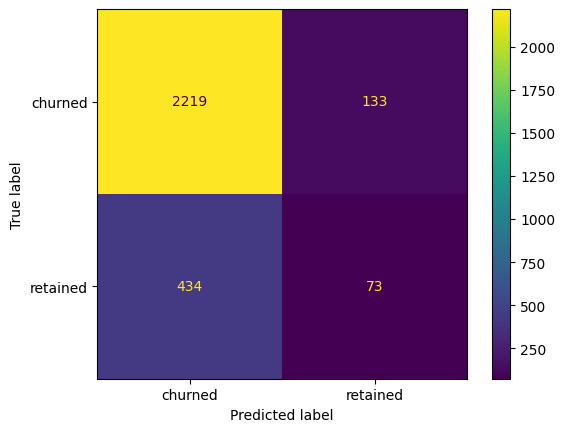

In [88]:
cm = confusion_matrix(y_test,xgb_test_preds,labels=xgb_cv.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['churned','retained']).plot()